<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we prepare the q1 dataset, q1 being training a model for predicting if a student has forgotten a word, given known words, known students in the test set. 

1. Preprocess the dataset:




Loading data:

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [3]:
datadfq1.head().transpose()

,7,15,20,21,22
p_recall,1.0,1.0,1.0,1.0,1.0
timestamp,1362082032,1362082130,1362082274,1362082274,1362082274
delta,444407,77,1634777,1708699,1708699
user_id,u:dDwF,u:dDwF,u:dDwF,u:dDwF,u:dDwF
learning_language,es,es,es,es,es
ui_language,en,en,en,en,en
lexeme_id,73eecb492ca758ddab5371cf7b5cca32,73eecb492ca758ddab5371cf7b5cca32,c84476c460737d9fb905dca3d35ec995,1a913f2ded424985b9c02d0436008511,38b770e66595fea718366523b4f7db3f
lexeme_string,bajo/bajo<pr>,bajo/bajo<pr>,niños/niño<n><m><pl>,leo/leer<vblex><pri><p1><sg>,libro/libro<n><m><sg>
history_seen,3,5,9,7,8
history_correct,3,5,8,5,8


The plan for pre processing is in the below table:

| column            	| example                                      	| modification plan                          	|
|-------------------	|----------------------------------------------	|--------------------------------------------	|
| p_recall          	| 1                                            	| change to p_forgot_bin, delete?            	|
| timestamp         	| 1362082032                                   	| keep as is for getting prev record data                         	|
| delta             	| 444407                                       	| change to days, hours, also get prev delta 	|
| user_id           	| u:dDwF                                       	| get total number of them, consider binary  	|
| learning_language 	| es                                           	| binary                                     	|
| ui_language       	| en                                           	| binary                                     	|
| lexeme_id         	| 73eecb492ca758ddab5371cf7b5cca32             	| binary?                                    	|
| lexeme_string     	| bajo/bajo<pr>                                	| decompose, character n-grams                     	|
| history_seen      	| 3                                            	| include, also get fraction                 	|
| history_correct   	| 3                                            	| include                                    	|
| session_seen      	| 1                                            	| include, get prev session seen,            	|
| session_correct   	| 1                                            	| include, prev session correct              	|
| student_word      	| (u:dDwF,   73eecb492ca758ddab5371cf7b5cca32) 	| delete                                     	|
| student_lang      	| (u:dDwF, en)                                 	| delete                                     	|

Changing p_recall to p_forgot_bin:

p_forgot = 1-p_recall
p_forgot_bin = , else 0. 

In [4]:
datadfq1['p_forgot'] = 1-datadfq1['p_recall']
datadfq1[['p_recall','p_forgot']].head()


,p_recall,p_forgot
7,1.0,0.0
15,1.0,0.0
20,1.0,0.0
21,1.0,0.0
22,1.0,0.0


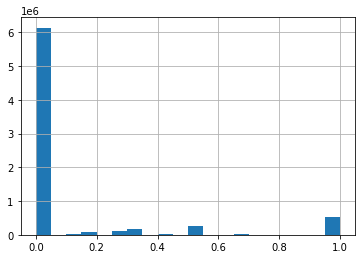

In [5]:
datadfq1['p_forgot'].hist(bins=20)

In [6]:
datadfq1['p_forgot_bin'] = np.where(datadfq1['p_forgot']==0,0,1)

In [7]:
datadfq1['p_forgot_bin'].value_counts(normalize=True)

0    0.838854
1    0.161146
Name: p_forgot_bin, dtype: float64

The dataset proportion of target variable is about the same as the full dataset from Duolingo_spaced_repetition.ipynb.

Next we pre process delta to a timedelta and then to days and hours. 

In [8]:
datadfq1['delta'].head()

7      444407
15         77
20    1634777
21    1708699
22    1708699
Name: delta, dtype: int64

In [9]:
datadfq1['delta_td'] = pd.to_timedelta(datadfq1['delta'],unit='s')

In [10]:
datadfq1['delta_td']

7           5 days 03:26:47
15          0 days 00:01:17
20         18 days 22:06:17
21         19 days 18:38:19
22         19 days 18:38:19
                 ...       
12854213    4 days 02:21:31
12854215    4 days 17:37:20
12854216    4 days 02:21:31
12854217    0 days 01:04:22
12854218    2 days 01:11:38
Name: delta_td, Length: 7313354, dtype: timedelta64[ns]

now we get total number of students

In [11]:
len(datadfq1['user_id'].unique())

88502

There are a lot of students. How do we model them?
 - drop them all (0)
 - convert all to binary, 88502 additional 
 - use a threshold frequency? 1000 additional
 - use mean and leave one out encodings - we'd have to have special time series based functions for this - since we wouldn't know the average for future values. pain.  - 5-10 additional, tiresome

First let's only consider 1000 students, drop user id, and see if we can consider just word dummies and get a good model. (We will do this after vectorizing the other columns and splitting).

We could also model 'session_correct' given session seen nad forget about p_forgot. although i get the feeling dataset would be imbalanced and that would show up in the regression somehow. 

Learning language binary dummies

In [12]:
LL_dummies = pd.get_dummies(datadfq1['learning_language'],prefix='LL_')
datadfq1 = pd.concat([datadfq1, LL_dummies],axis=1)

UI language binary dummies

In [13]:
UIL_dummies = pd.get_dummies(datadfq1['ui_language'],prefix='UIL_')
datadfq1 = pd.concat([datadfq1, UIL_dummies],axis=1)

In [14]:
datadfq1.shape

(7313354, 25)

In [22]:
datadfq1.select_dtypes(include = ['int','float','uint']).describe()

,p_recall,timestamp,delta,history_seen,history_correct,session_seen,session_correct,p_forgot,p_forgot_bin
count,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06,7.313354e+06
mean,8.960493e-01,1.362588e+09,7.170795e+05,2.173827e+01,1.910721e+01,1.805186e+00,1.631853e+00,1.039507e-01,1.611458e-01
std,2.712432e-01,2.929682e+05,2.188559e+06,1.301338e+02,1.128391e+02,1.310896e+00,1.274489e+00,2.712432e-01,3.676654e-01
min,0.000000e+00,1.362082e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.362342e+09,5.350000e+02,3.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.362590e+09,7.725800e+04,6.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.362844e+09,4.401430e+05,1.500000e+01,1.300000e+01,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.363105e+09,3.975837e+07,1.351800e+04,1.288800e+04,2.000000e+01,2.000000e+01,1.000000e+00,1.000000e+00


We only want to keep the following columns for modeling q1 from datadfq1.

1. p_forgot_bin
2. delta (keeping as integer)
3. delta
4. history_seen
5. history_correct
6. LL dummies
7. UIL dummies

We have no information about students or sessions or time series based information. We will save this as q1_fulldataset1

In [24]:
list(datadfq1.columns)

['p_recall',
 'timestamp',
 'delta',
 'user_id',
 'learning_language',
 'ui_language',
 'lexeme_id',
 'lexeme_string',
 'history_seen',
 'history_correct',
 'session_seen',
 'session_correct',
 'student_word',
 'student_lang',
 'p_forgot',
 'p_forgot_bin',
 'delta_td',
 'LL__en',
 'LL__es',
 'LL__fr',
 'LL__it',
 'LL__pt',
 'UIL__en',
 'UIL__es',
 'UIL__pt']

In [25]:
q1_fulldataset1 = datadfq1[[
 'delta',
 'history_seen',
 'history_correct',
 'p_forgot_bin',
 'LL__en',
 'LL__es',
 'LL__fr',
 'LL__it',
 'LL__pt',
 'UIL__en',
 'UIL__es',
 'UIL__pt']]
compressed_pickle(path_name+"q1_fulldataset_wordsonly",q1_fulldataset1)

Next we decompose lexeme_strings. 

## 2. Getting word based features by decomposing lexemes<br> 
saving with key as lexeme id, learning language and ui language as columns as well.

In [15]:
all_lexemes = datadfq1.loc[:,['lexeme_id','learning_language','lexeme_string']].drop_duplicates()

In [16]:
all_lexemes.shape

(12160, 3)

There are 12,160 unique words (counting repeated words in each language as separate).

Decomposing the lexeme string into individual features:

In [17]:
all_lexemes['surface_form'] = all_lexemes['lexeme_string'].apply(lambda x: x[0:x.find('/')])
all_lexemes['not_surface_form'] = all_lexemes['lexeme_string'].apply(lambda x: x[x.find('/')+1:])

all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo<pr>
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño<n><m><pl>
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer<vblex><pri><p1><sg>
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro<n><m><sg>
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a<pr>


In [18]:
all_lexemes['lemma_form'] = all_lexemes['not_surface_form'].apply(lambda x: x[:x.find('<')])
all_lexemes['not_lemma_form'] = all_lexemes['not_surface_form'].apply(lambda x: x[x.find('<'):])
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form,lemma_form,not_lemma_form
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo<pr>,bajo,<pr>
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño<n><m><pl>,niño,<n><m><pl>
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer<vblex><pri><p1><sg>,leer,<vblex><pri><p1><sg>
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro<n><m><sg>,libro,<n><m><sg>
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a<pr>,a,<pr>


In [19]:
all_lexemes['pos'] = all_lexemes['not_lemma_form'].apply(lambda x: x[x.find('<')+1:x.find('>')])
all_lexemes['not_pos'] = all_lexemes['not_lemma_form'].apply(lambda x: x[x.find('>')+1:])
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form,lemma_form,not_lemma_form,pos,not_pos
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo<pr>,bajo,<pr>,pr,
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño<n><m><pl>,niño,<n><m><pl>,n,<m><pl>
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer<vblex><pri><p1><sg>,leer,<vblex><pri><p1><sg>,vblex,<pri><p1><sg>
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro<n><m><sg>,libro,<n><m><sg>,n,<m><sg>
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a<pr>,a,<pr>,pr,


In [20]:
all_lexemes['modstrings'] = all_lexemes['not_pos'].apply(lambda x: [y[y.find('<')+1:] for y in x.split('>') if len(y)>=1])
try:
  del all_lexemes['not_surface_form'], all_lexemes['not_lemma_form'], all_lexemes['not_pos']
except:
  pass
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[]
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]"
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]"
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]"
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[]


Getting length of surface form word (what the students see)

In [21]:
all_lexemes['sf_length'] = all_lexemes['surface_form'].apply(len)

Getting dummies for each value in the modstrings list

In [22]:
all_lexemes['modstrings'].explode()

7           NaN
20            m
20           pl
21          pri
21           p1
           ... 
12832145    ifi
12832145     p3
12832145     sg
12844305      f
12844305     sg
Name: modstrings, Length: 25498, dtype: object

In [23]:
all_lexemes = pd.concat([all_lexemes,pd.get_dummies(all_lexemes['modstrings'].apply(pd.Series).stack(),prefix='mod').sum(level=0)],axis=1)
all_lexemes.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """Entry point for launching an IPython kernel.


,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
all_lexemes.fillna(0)

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12818467,822db15e4e056837f908d47692f6969e,pt,ajuda/ajudar<vblex><pri><p3><sg>,ajuda,ajudar,vblex,"[pri, p3, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12820313,aa25ea9dc156919749f444521720432c,fr,conférence/conférence<n><f><sg>,conférence,conférence,n,"[f, sg]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12820316,3db97fbbdd0d4e08b8248b6219a86e4b,fr,liens/lien<n><m><pl>,liens,lien,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12832145,8b53845a67433bd62179e23bcb88b5c3,pt,foi/ir<vblex><ifi><p3><sg>,foi,ir,vblex,"[ifi, p3, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We will also get the number of accented or modified letters in the word. 
We will do this by counting any characters that have ascii value oustide of 97 to 122 (closed interval) - would have to be more specific.

In [25]:
'é'.isalpha()

True

In [50]:
ord('é'),ord('è')

(233, 232)

In [56]:
chr(224),

'à'

In [31]:
ord('a'),ord('z')

(97, 122)

In [26]:
def num_accented(word):
  # have to be more specific
  return sum([1 for c in word if (ord(c)<97 or ord(c)>122) and c.isalpha()])

In [27]:
num_accented('niñosco-nférence')

2

Are there any spaces in the surface form?

In [28]:
all_lexemes.loc[~all_lexemes['surface_form'].str.isalpha()]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
72,6e820e73c9936c1c90e20a174f3dd1ad,pt,<*sf>/traje<n><m><*numb>,<*sf>,traje,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,38ec3b04540c300424b556dee6e5dbe5,pt,<*sf>/chapéu<n><m><*numb>,<*sf>,chapéu,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,6e39fa977508d7c2e5990cfddc80b2f7,pt,<*sf>/fantasia<n><f><*numb>,<*sf>,fantasia,n,"[f, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,b70b44f07b89cc7c5ac2626029a8952a,pt,<*sf>/sapato<n><m><*numb>,<*sf>,sapato,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,9efffbcb52dac1660ecdbf050ec6dfc6,pt,<*sf>/camisa<n><f><*numb>,<*sf>,camisa,n,"[f, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12540979,24cff24fb4e501b59c3b19d54c74e18c,it,<*sf>/benessere<n><m><*numb>,<*sf>,benessere,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12540980,d7e0fb52c301d94b0da0718bf9874b54,it,<*sf>/occhio<n><m><*numb>,<*sf>,occhio,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12579510,289ec4ae458f4741f9401eb234dd29a3,pt,<*sf>/acontecer<vblex><prs><*pers><*numb>,<*sf>,acontecer,vblex,"[prs, *pers, *numb]",5,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12623950,6633292d640dda65f2160fcf2bbb0e2d,pt,<*sf>/pegar<vblex><prs><*pers><*numb>,<*sf>,pegar,vblex,"[prs, *pers, *numb]",5,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a number of strings with surface_form = <*sf>.
For these we will impute as surface of lemma instead. 

In [29]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','sf_length'] = all_lexemes['lemma_form'].apply(len)

In [30]:
all_lexemes.loc[~all_lexemes['lemma_form'].str.isalpha()]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
293,78b9b97a0aaf3ce9102280144c693fd5,en,'s/'s<gen>,'s,'s,gen,[],2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6187,ef45360f43e0f4493eaabb78597c3700,fr,jusqu'à/jusqu'à<pr>,jusqu'à,jusqu'à,pr,[],7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13560,3ba531b974960974d85f6fdc1e4ce4b4,fr,aujourd'hui/aujourd'hui<adv>,aujourd'hui,aujourd'hui,adv,[],11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25135,a764529f0fc469edb546dd10d9346fb5,fr,demi-heure/demi-heure<n><f><sg>,demi-heure,demi-heure,n,"[f, sg]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28640,56b70d709d1189b431467d50ae65836a,fr,petit-déjeuner/petit-déjeuner<n><m><sg>,petit-déjeuner,petit-déjeuner,n,"[m, sg]",14,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29546,2b7e37bdf38f36464c887d15a8e05e08,fr,rendez-vous/rendez-vous<n><m><sp>,rendez-vous,rendez-vous,n,"[m, sp]",11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48800,4a1a429b3f6883aa83b855c0e62339cd,fr,états-unis/états-unis<np><loc><f><pl>,états-unis,états-unis,np,"[loc, f, pl]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84616,13263060ceabe62314d3afd0ab0666cb,pt,<*sf>/sexta-feira<n><f><*numb>,<*sf>,sexta-feira,n,"[f, *numb]",11,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184278,651e525355a96d12b1789b8c544a7678,fr,d'après/d'après<pr>,d'après,d'après,pr,[],7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201540,bc3a266cbae06e3d755d7939c4b9d2eb,fr,<*sf>/soixante-dix<num><mf><*numb>,<*sf>,soixante-dix,num,"[mf, *numb]",12,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can replace the surface form with '' if it is <sf*>

In [49]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','surface_form'] = ''

There are a number that are hyphenated, and one apostrophe in the lemma form. We will create columns for these as well, has hyphen and has apostrophe

In [50]:
all_lexemes[all_lexemes['surface_form'].str.contains(' ')]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn,num_tokens,num_accents,num_spchar
119779,0f2b3dc0128462eef8527a186d1964a5,es,buenas noches/bueno<adj><f><pl>,buenas noches,bueno,adj,"[f, pl]",13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0
1826484,93df9b1cd6de98003586347d6fe4a21d,es,buenos días/buenos días<ij>,buenos días,buenos días,ij,[],11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0


In [51]:
all_lexemes = all_lexemes.fillna(0)

In [52]:
all_lexemes['num_tokens'] = all_lexemes['surface_form'].apply(lambda x: len(x.split(' ')))

In [53]:
all_lexemes['num_accents'] = all_lexemes['surface_form'].apply(num_accented)

In [54]:
all_lexemes['num_spchar'] = all_lexemes['surface_form'].apply(lambda x: sum([1 for c in x if (not c.isalpha()) and c!=' ']))

In [55]:
all_lexemes.columns

Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
       'lemma_form', 'pos', 'modstrings', 'sf_length', 'mod_*gndr',
       'mod_*numb', 'mod_*pers', 'mod_@compound_past', 'mod_@cond_perfect',
       'mod_@det:a_le', 'mod_@det:de_le', 'mod_@formal', 'mod_@future',
       'mod_@future_perfect', 'mod_@future_phrasal', 'mod_@ger_past',
       'mod_@n:petit_ami', 'mod_@neg:il_ne_y_a', 'mod_@obj', 'mod_@passive',
       'mod_@past', 'mod_@past_cond', 'mod_@past_inf', 'mod_@past_perfect',
       'mod_@past_subjunctive', 'mod_@pluperfect', 'mod_@pos',
       'mod_@present_perfect', 'mod_@prn:ce_dont', 'mod_@prn:celui_ci',
       'mod_@prn:celui_la', 'mod_@prn:celui_que', 'mod_@prn:l_un',
       'mod_@prn:le_mien', 'mod_@prn:le_tien', 'mod_@prn:quelque_chose',
       'mod_@prn:quelque_un', 'mod_@ref', 'mod_@subjunctive_pluperfect',
       'mod_acr', 'mod_adv', 'mod_an', 'mod_ant', 'mod_cni', 'mod_comp',
       'mod_def', 'mod_dem', 'mod_det', 'mod_dim', 'mod_enc', 'mod

TFIDF vectorization of character n-grams (2 to 4 characters long). 

In [56]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','surface_form']

Series([], Name: surface_form, dtype: object)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = all_lexemes['surface_form']
vect = TfidfVectorizer(analyzer = 'char_wb',ngram_range = (2,4),min_df=2,max_df = 0.7,max_features=3000)
X = vect.fit_transform(corpus)
print(vect.get_feature_names_out())
print(X.shape)

[' a' ' a ' ' ab' ... 'ó ' 'ón' 'ón ']
(12160, 3000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


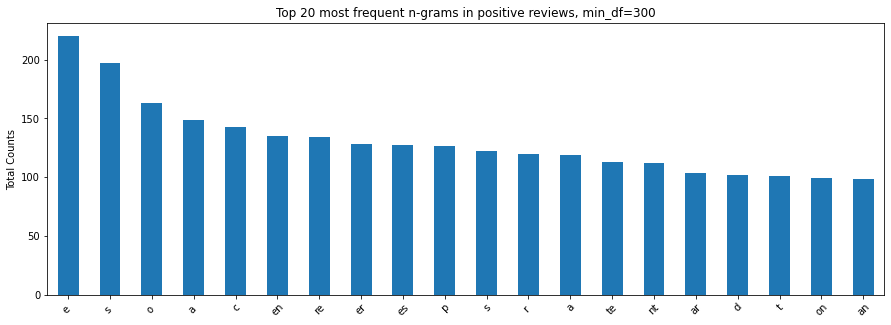

In [58]:
charseq = pd.DataFrame(
    {"tfidf": X.toarray().sum(axis=0)},
    index=vect.get_feature_names()
).sort_values("tfidf", ascending=False)

charseq.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequent n-grams in positive reviews, min_df=300")
plt.ylabel("Total Counts")
plt.xticks(rotation=45)
plt.show()

In [59]:
features_with_space = [seq for seq in vect.get_feature_names_out() if (' ' in seq)]

In [60]:
len(features_with_space)

866

In [61]:
indices = [list(vect.get_feature_names_out()).index(seq) for seq in features_with_space]

In [62]:
len(indices)

866

In [63]:
features_nospaces = [seq for seq in list(vect.get_feature_names_out()) if ' ' not in seq]

In [64]:
len(features_nospaces)

2134

In [65]:
2134+866

3000

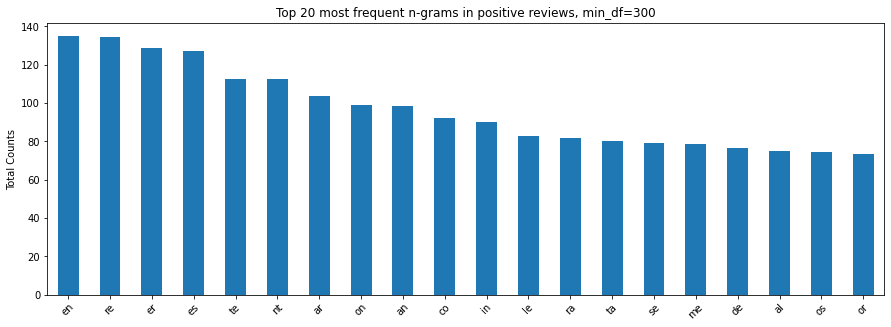

In [66]:
X_nospaces = X[:,[ind for ind in range(X.shape[1]) if ind not in indices]].toarray()
charseq = pd.DataFrame(
    {"tfidf": X_nospaces.sum(axis=0)},
    index=features_nospaces
).sort_values("tfidf", ascending=False)

charseq.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequent n-grams in positive reviews, min_df=300")
plt.ylabel("Total Counts")
plt.xticks(rotation=45)
plt.show()

In [67]:
all_lexemes = all_lexemes.reset_index()

In [68]:
all_lexemes = pd.concat([all_lexemes,pd.DataFrame(X_nospaces,columns=features_nospaces)],axis=1)

In [69]:
all_lexemes.columns

Index(['index', 'lexeme_id', 'learning_language', 'lexeme_string',
       'surface_form', 'lemma_form', 'pos', 'modstrings', 'sf_length',
       'mod_*gndr',
       ...
       'êt', 'ête', 'ía', 'ían', 'ías', 'ín', 'ît', 'ña', 'ño', 'ón'],
      dtype='object', length=2231)

We have 2233 word based features in all_lexemes. we will save this to the word features file. 

In [70]:
compressed_pickle(path_name+"q1_lexeme_features",all_lexemes)

We purposely vectorized before splitting because we don't want to get thrown unknown features yet. 

Dataset types:

1. no student information
2. timestamp based student based features?

EDA

In [ ]:

# this errors out for lack of space even with high-RAM
# datadfq1_1 = pd.merge(left = datadfq1,right = all_lexemes, how="left",left_on = 'lexeme_id',right_on = 'lexeme_id')

In [ ]:
datadfq1_1.shape, 

We;re running into issues joining datadfq_1 (Unseen_words_training_set.pbz2)with the all_lexemes dataet. (saved in q1_lexeme_features.pbz2)

Will try the following in the next dataset.
0. try doing some descriptive EDAs (statistical tests two sample t-test as well as Mann Whitney U) 
1. change rest of datadfq1 numerics to sparse dataset
2. try PCA with lexeme features and then joining (bring down to 200 or so)